In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision.datasets import EMNIST
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm


def show_score_map(model, X):
    xr = torch.linspace(X[:,0].min(), X[:,0].max(), 100)
    yr = torch.linspace(X[:,1].min(), X[:,1].max(), 100)
    x_, y_ = torch.meshgrid(xr, yr)
    X_ = torch.cat((x_.reshape((-1,1)), y_.reshape(-1,1)),1)
    with torch.no_grad():
        s_ = model.score_reconstruction(X_).reshape(len(xr), len(yr))
        plt.imshow(s_.T, cmap = 'jet')
        plt.title('score')
        plt.xlabel('x axis')
        plt.ylabel('y axis')
        plt.show()
        plt.imshow(np.log(s_.T), cmap = 'jet')
        plt.title('log score')
        plt.xlabel('x axis')
        plt.ylabel('y axis')
        plt.show()

def roc(y, N = 100, display = True):
    T = torch.linspace(0, y.max(), N)
    tpr, fpr = [],[]
    for T_ in T:
        yt = torch.tensor([(-1 if y_ else 1) for y_ in y > T_])
        tpr.append(torch.logical_and(yt == -1, l == -1).sum() / (l == -1).sum())  
        fpr.append(torch.logical_and(yt == -1, l == 1).sum() / (l == 1).sum())
    if display:
        plt.plot(fpr, tpr, '--')
        plt.xlabel('false positive ratio (FP / N)')
        plt.ylabel('true positive ratio (TP / P)')
        plt.show()
    return tpr, fpr

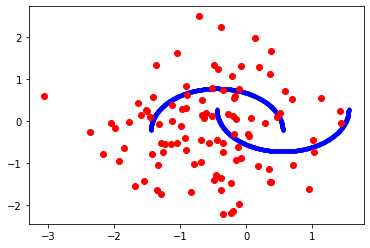

In [2]:
np.random.seed(42)
from sklearn.datasets import make_moons
Xn = make_moons(n_samples=1000, noise=False, random_state=42)[0]
Xa = np.random.randn(100,2)
X = np.concatenate((Xn,Xa))
X -= X.mean(0) 

l = torch.cat((torch.ones(Xn.shape[0]), -torch.ones(Xa.shape[0])))

plt.plot(X[l==1,0],X[l==1,1],'b.')
plt.plot(X[l==-1,0],X[l==-1,1],'ro')
# plt.title('Generated Samples')
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

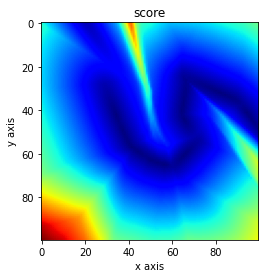

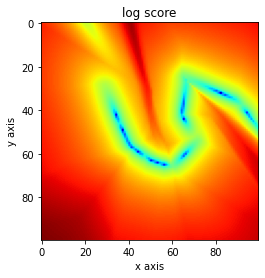

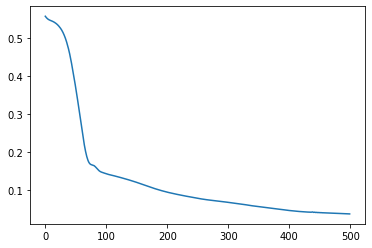

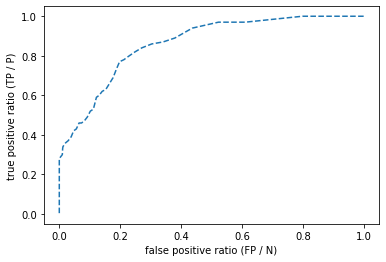

In [8]:
from torch.nn.modules import ReLU
from torch.linalg import vector_norm 

torch.manual_seed(44)

class LinearAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 1))
        self.dec = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 2))
    def score_reconstruction(self, x):
        ''' 
        || x - x_hat ||_2 where x_hat = dec(enc(x))
        '''
        x_hat = self(x)
        return vector_norm(x_hat - x, dim=-1)

    def forward(self, x):
        return self.dec(self.enc(x))

epochs = 500
model = LinearAutoencoder()
optimizer = optim.Adam(list(model.enc.parameters()) + 
                       list(model.dec.parameters()), 
                       lr = 0.0025, 
                       weight_decay = 10e-5)
losses = []
X_ = torch.tensor(X).float()


for epoch in tqdm(range(epochs)):
    # anomaly score
    X_hat = model(X_)

    # tranining 
    loss = F.mse_loss(X_hat, X_)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
show_score_map(model, X)
plt.plot(losses)
plt.show()
tpr, fpr = roc(model.score_reconstruction(torch.tensor(X).float()).detach())

In [9]:
torch.save({'fpr' : fpr, 'tpr' : tpr, 'X' : X , 'l' : l, 'model' : model.state_dict()}, 'Autoenc.torch')

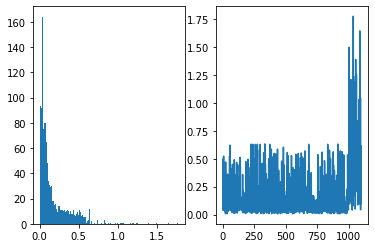

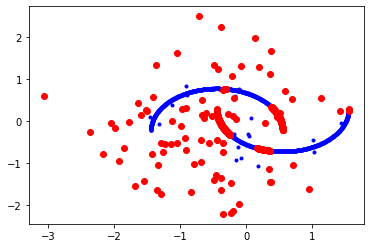

In [10]:
# plt.hist(s.detach(),128)
with torch.no_grad():
    s = model.score_reconstruction(torch.tensor(X).float())
    anomalies = (s - s.mean()) > 0.01
    plt.subplot(121)
    plt.hist(s,128)
    plt.subplot(122)
    plt.plot(s)
    plt.show()
    plt.plot(X[~anomalies,0],X[~anomalies,1],'b.')
    plt.plot(X[anomalies,0],X[anomalies,1],'ro')
    plt.show()

# Example with training MNIST & EMNIST

In [ ]:
train_loader = torch.utils.data.DataLoader(
  MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 # (0.1307,), (0.3081,))
                                 (0.5),(0.5,))
                             ])),
  batch_size=1024, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    EMNIST(root="files/", split="byclass", download=True, train=True, 
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.5),(0.5,))
                ])),
    batch_size=1024)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting files/EMNIST/raw/gzip.zip to files/EMNIST/raw


In [ ]:
class View(nn.Module):
    ''' 
    There is unforutnately no module for reshaping array in nn.Sequence
    so we have our tiny implementation
    '''
    
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class MNISTNetwork(nn.Module):
    def __init__(self):
        super(MNISTNetwork, self).__init__()
        '''
        # CNN, for those who want to play a bit with it
        self.encoder = nn.Sequential(
            nn.Conv2d(1,1,(5,5)),
            # nn.ReLU(),
            nn.Conv2d(1,1,(5,5)),
            # nn.ReLU(),
            nn.Conv2d(1,1,(5,5)),
            # nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 8))
        
        self.decoder = nn.Sequential(
            nn.Linear(8, 256),
            View((-1,1,16,16)),
            nn.ConvTranspose2d(1, 1, (5,5)),
            nn.ConvTranspose2d(1, 1, (5,5)),
            nn.ConvTranspose2d(1, 1, (5,5))
        )
        '''

        # Linear, 
        # proably the simplest and the most straightforward architecture
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 784),
            View((-1,1,28,28)))
    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return z,x_rec

    def score_reconstruction(self, x):
        _, x_rec = self(x)
        return torch.sqrt(torch.sum((x - x_rec).reshape((x.shape[0], -1)) ** 2, dim = -1))

device = 'cpu'
epochs = 10
model = MNISTNetwork().to(device)

  0%|          | 0/10 [00:00<?, ?it/s]

0 0.2904815375804901


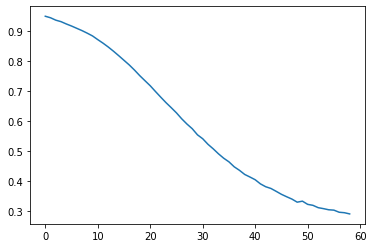

1 0.2550719380378723


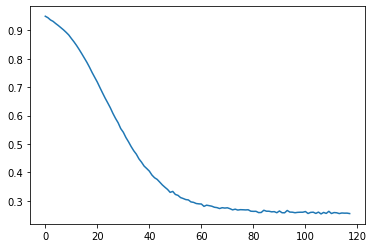

2 0.2370627373456955


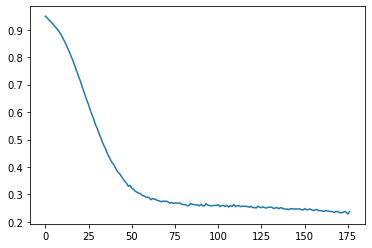

3 0.20454798638820648


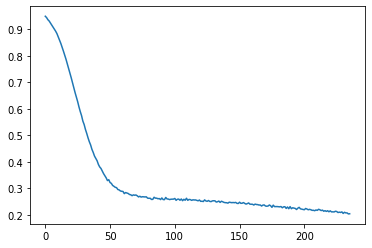

4 0.17707064747810364


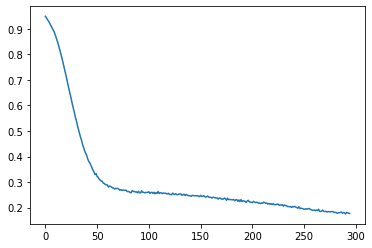

5 0.1623154878616333


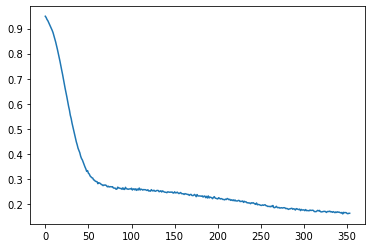

6 0.15119683742523193


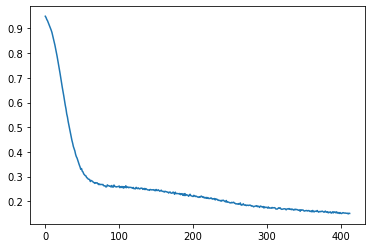

7 0.149351567029953


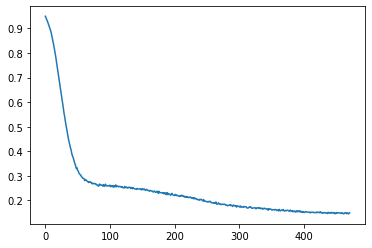

8 0.14371222257614136


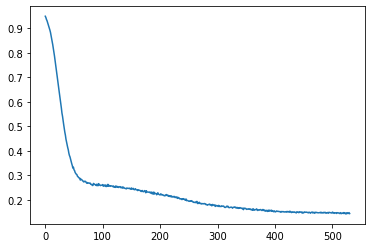

9 0.14271289110183716


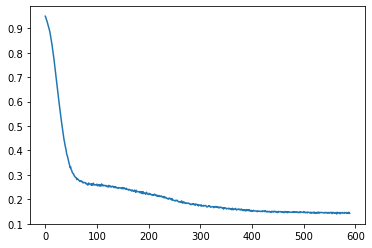

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
losses = []
for epoch in tqdm(range(epochs)):
    for i, (batch,_) in enumerate(train_loader):
        batch = batch.to(device)

        # forward
        x_rec = model(batch)[1]

        # optimisation 
        loss = F.mse_loss(batch, x_rec)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(epoch, losses[-1])
    plt.plot(losses)
    plt.show()

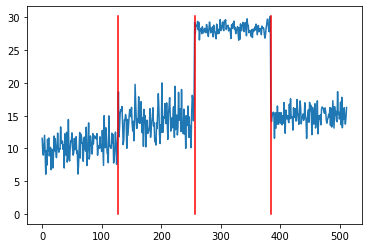

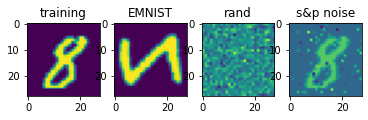

In [ ]:
def salt_and_pepper(x, ratio):
    N = int(ratio * x.numel())
    indices = torch.randint(0,x.numel(),(N,))
    x[indices] = torch.randn(N)
    return x

N = 128
batch_train = next(iter(train_loader))[0][:N]
batch_test = next(iter(test_loader))[0][:N]

with torch.no_grad():
    # random noise
    x_random = torch.randn((batch_train.shape[0],1,28,28))
    # salt and pepper
    x_sp = batch_train.clone()
    x_sp = salt_and_pepper(x_sp.ravel(),0.1).reshape(x_sp.shape)
    # EMNIST

    batch_ = torch.cat((batch_train,batch_test, x_random,x_sp))
    s = model.score_reconstruction (batch_)
    plt.plot(s)
    plt.plot([N,N],[0,s.max()],'r-')
    plt.plot([2*N,2*N],[0,s.max()],'r-')
    plt.plot([3*N,3*N],[0,s.max()],'r-')
    plt.show()

    plt.subplot(141)
    plt.imshow(batch_train[0,0,...])
    plt.title('training')
    plt.subplot(142)
    plt.imshow(batch_test[0,0,...])
    plt.title('EMNIST')
    plt.subplot(143)
    plt.title('rand')
    plt.imshow(x_random[0,0,...])
    plt.subplot(144)
    plt.title('s&p noise')
    plt.imshow(x_sp[0,0,...])

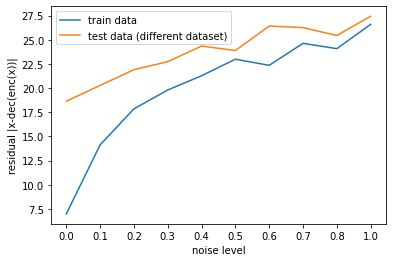

In [ ]:
def noise_levels(x, noise_range, show = True):
    scores = []
    for noise in noise_range:
        x_sp = salt_and_pepper(x.clone().ravel(),noise).reshape(x.shape)
        with torch.no_grad():
            _, x_rec = model(x_sp)
            score = model.score_reconstruction(x_sp)
        if show:
            plt.subplot(121)
            plt.imshow(x_sp[0,...].cpu())
            plt.title(str(noise.item()))
            plt.subplot(122)
            print(x_rec.shape, x_sp.shape)
            plt.imshow(x_rec[0,0,...].cpu())
            plt.title(str(score[0].item()))
            plt.show()
        scores.append(score)
    return scores

noise_range = torch.linspace(0,1,10)
x_train = next(iter(train_loader))[0]
x_test = next(iter(test_loader))[0]
scores_train = noise_levels(x_train[[0],[0],...], noise_range, False)
scores_test = noise_levels(x_test[[0],[0],...], noise_range, False)

plt.plot(torch.tensor(scores_train).numpy())
plt.plot(torch.tensor(scores_test).numpy())
plt.legend(['train data', 'test data (different dataset)'])
plt.xticks(range(len(noise_range)), (noise_range.numpy() * 10).astype(np.int32).astype(np.float32)/10 )
plt.xlabel('noise level')
plt.ylabel('residual |x-dec(enc(x))|')
plt.show()